# 📊 E-news Express A/B Testing Project
---

## Problem Definition & Questions

**Business Problem**: E-news Express wants to evaluate whether a new landing page improves user engagement and subscriptions.

**Questions:**
1. Do users spend more time on the new landing page than the old landing page?
2. Is the conversion rate for the new page greater than for the old page?
3. Does conversion depend on preferred language?
4. Is mean time on the new page the same across languages?

## Data Background & Dictionary
- **user_id**: Unique user identifier
- **group**: Control (old page) or Treatment (new page)
- **landing_page**: Version of page shown (old/new)
- **time_spent_on_the_page**: Minutes spent
- **converted**: Subscription status (0/1 or yes/no)
- **language_preferred**: User’s chosen language

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [34]:
# Load dataset
df = pd.read_csv('abtest.csv')
df.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


## Data Cleaning & Preparation

In [39]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB
None


In [41]:
print('\nNulls per column:\n', df.isnull().sum())


Nulls per column:
 user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64


In [43]:
print('\nDuplicates in user_id:', df.duplicated('user_id').sum())


Duplicates in user_id: 0


In [45]:
print('\nGroup vs Landing Page consistency:')
print(pd.crosstab(df['group'], df['landing_page']))


Group vs Landing Page consistency:
landing_page  new  old
group                 
control         0   50
treatment      50    0


## Exploratory Data Analysis (EDA)
### Univariate Analysis

In [48]:
df['time_spent_on_the_page'].describe()

count    100.000000
mean       5.377800
std        2.378166
min        0.190000
25%        3.880000
50%        5.415000
75%        7.022500
max       10.710000
Name: time_spent_on_the_page, dtype: float64

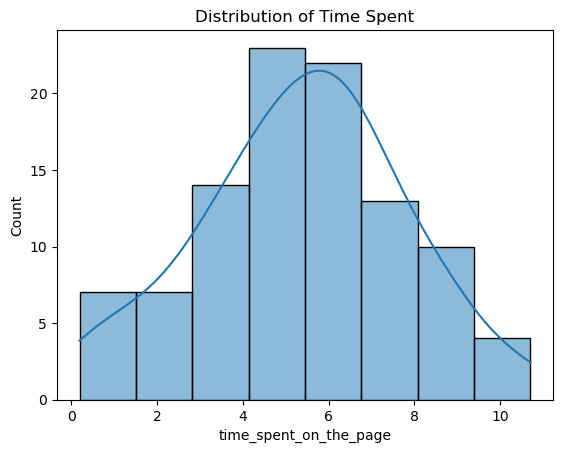

In [69]:
sns.histplot(df['time_spent_on_the_page'], kde=True)
plt.title('Distribution of Time Spent')
plt.show()

#### Observations:
* Most users spend around 5–6 minutes on the landing page, showing decent engagement.
* A few users leave quickly (0–2 minutes), which may indicate the page is not immediately capturing attention.
* Since the company wants users to stay long enough to subscribe, increasing early engagement (first 2 mins) is critical.

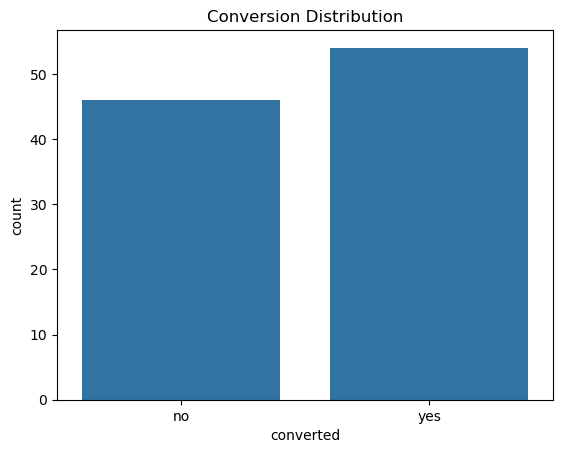

In [71]:
sns.countplot(x='converted', data=df)
plt.title('Conversion Distribution')
plt.show()

#### Observations:
* Slightly more than half of the users converted (subscribed), which is a positive sign.
* However, a large share still didn’t convert, showing room for improvement.
* This supports the company’s concern — page design and engagement play a key role in influencing subscription decisions.

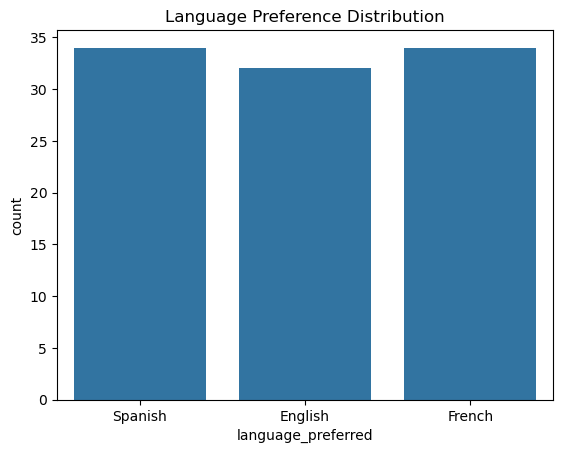

In [73]:
sns.countplot(x='language_preferred', data=df)
plt.title('Language Preference Distribution')
plt.show()

#### Observations:
* Users are almost evenly split across English, French, and Spanish.
* This means the company serves a diverse audience, so language inclusivity is important.
* No single language dominates, so the landing page design and messaging must work equally well across all languages to maximize conversions.

### Bivariate Analysis

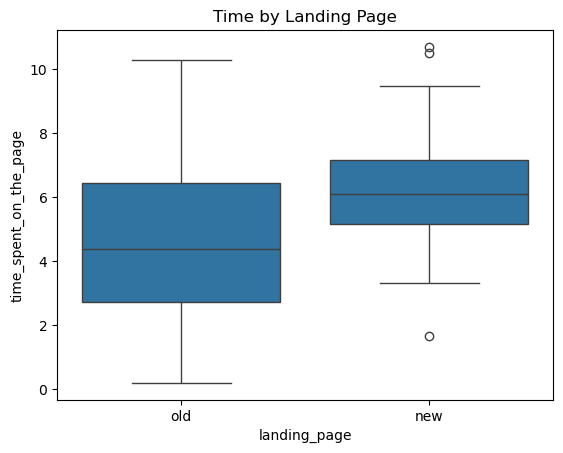

In [75]:
sns.boxplot(x='landing_page', y='time_spent_on_the_page', data=df)
plt.title('Time by Landing Page')
plt.show()

#### Observations:
* Users on the new landing page spend more time (median ~6 minutes) compared to the old page (median ~4 minutes).
* The spread of time on the new page is tighter, suggesting more consistent engagement.
* This indicates that the new design keeps users engaged longer, which is likely to improve subscription chances.

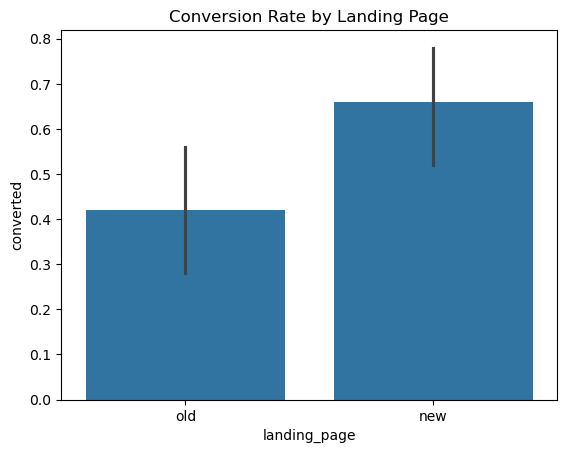

In [98]:
sns.barplot(x='landing_page', y=df['converted'].apply(lambda x: 1 if str(x).lower() in ['yes','1','true'] else 0), data=df)
plt.title('Conversion Rate by Landing Page')
plt.show()

#### Observations:
* The new landing page leads to a higher conversion rate compared to the old one.
* This suggests that the new design is more effective at converting users.

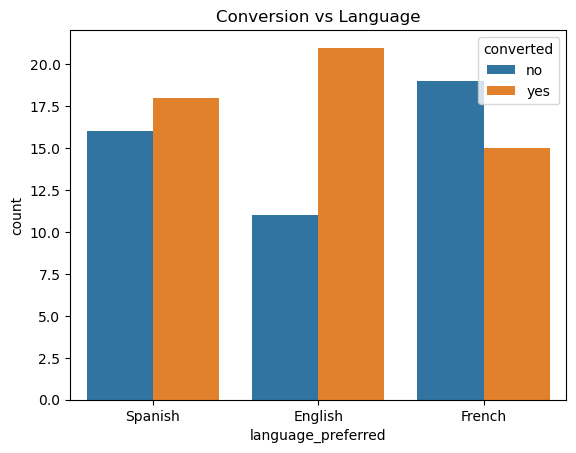

In [103]:
sns.countplot(x='language_preferred', hue='converted', data=df)
plt.title('Conversion vs Language')
plt.show()

#### Observations:
* Best performing language group: English speakers (strongly positive conversions).
* Moderate: Spanish speakers (almost balanced, slightly positive conversions).
* Weakest: French speakers (more users did not convert than did).

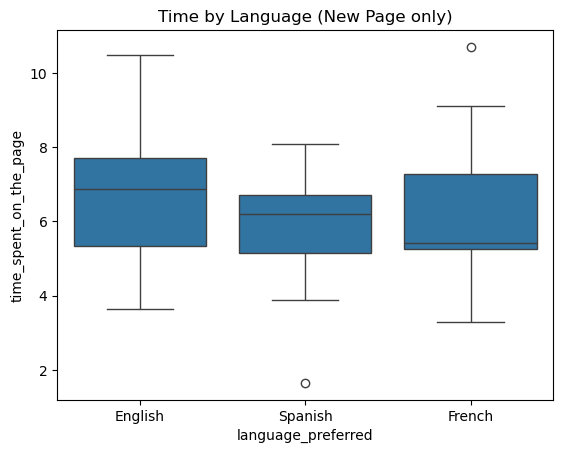

In [106]:
sns.boxplot(x='language_preferred', y='time_spent_on_the_page', data=df[df['landing_page']=='new'])
plt.title('Time by Language (New Page only)')
plt.show()

#### Observations:
* English speakers → spend the most time on the new page (highest median).
* Spanish speakers → consistent time but slightly lower than English.
* French speakers → spend the least time on average, though a few spend a lot (outliers).

## Hypothesis Tests

### Q1: Do users spend more time on the new landing page?
- **H0:** μ_new <= μ_old
- **H1:** μ_new > μ_old
- Test: Welch’s t-test (one-tailed)

In [57]:
old_time = df[df['landing_page']=='old']['time_spent_on_the_page']
new_time = df[df['landing_page']=='new']['time_spent_on_the_page']

t_stat, p_two = stats.ttest_ind(new_time, old_time, equal_var=False)
p_one = p_two/2 if t_stat>0 else 1-p_two/2
print('t-stat:', t_stat, 'One-tailed p:', p_one)

t-stat: 3.7867702694199856 One-tailed p: 0.0001392381225166549


* t-statistic = 3.79 → This is the test statistic; higher means stronger evidence against H₀.
* p-value (one-tailed) ≈ 0.00014 → This is much smaller than common significance levels (0.05 or 0.01).
* Since p-value < 0.05, we reject H₀.
* There is very strong evidence that users spend more time on the new landing page than on the old one.

### Q2: Is conversion rate higher on new page?
- **H0:** p_new <= p_old
- **H1:** p_new > p_old
- Test: Two-proportion z-test

In [60]:
conv_counts = df.groupby('landing_page')['converted'].apply(lambda x: (x=='yes').sum())
n_obs = df['landing_page'].value_counts().sort_index()

z_stat, p_val = proportions_ztest(count=conv_counts, nobs=n_obs, alternative='larger')
print('z-stat:', z_stat, 'p-value:', p_val)

z-stat: 2.4077170617153842 p-value: 0.008026308204056278


* z-statistic = 2.41 → A positive value, meaning conversions on the new page look higher.
* p-value ≈ 0.008 → This is much smaller than 0.05 (and even below 0.01).
* Since p-value < 0.05, we reject H₀.
* There is strong statistical evidence that the new landing page has a higher conversion rate than the old page.

### Q3: Does conversion depend on language?
- **H0:** Conversion independent of language
- **H1:** Conversion depends on language
- Test: Chi-square Independence

In [124]:
cont = pd.crosstab(df['language_preferred'], df['converted'])
chi2, p_val, dof, exp = stats.chi2_contingency(cont)
print('Chi2:', chi2, 'p-value:', p_val)

Chi2: 3.0930306905370832 p-value: 0.2129888748754345


* Chi2 statistic = 3.09 → A small value, indicating not much difference in distribution between language preference and conversion.
* p-value = 0.213 → This is greater than 0.05.
* Since p-value > 0.05, we fail to reject H₀.
* There is no strong statistical evidence that conversion depends on language preference.
* Conversion appears to be independent of language.

### Q4: Is mean time same across languages on new page?
- **H0:** μ_English = μ_French = μ_Spanish
- **H1:** At least one mean different
- Test: One-Way ANOVA

In [66]:
df_new = df[df['landing_page']=='new']
groups = [grp['time_spent_on_the_page'].values for _, grp in df_new.groupby('language_preferred')]
F, p_val = stats.f_oneway(*groups)
print('F-stat:', F, 'p-value:', p_val)

F-stat: 0.8543992770006822 p-value: 0.43204138694325955


* F-statistic = 0.854 → A small value, indicating little variation in time spent across language groups.
* p-value = 0.432 → This is much greater than 0.05.
* Since p-value > 0.05, we fail to reject H₀.
* There is no strong statistical evidence that the mean time spent on the new page differs by language.
* The average time spent on the new landing page appears to be the same across English, French, and Spanish users.

## Conclusion
* Users spend significantly more time on the new landing page compared to the old one.
* The conversion (subscription) rate is significantly higher on the new page.
* Language preference does not impact conversion or time spent.
* Most users spend around 5–6 minutes on the page, but some leave early (0–2 mins).
* English speakers perform best, French speakers perform weakest in conversions.
* Overall, the new landing page design is clearly more effective at engaging users and encouraging subscriptions.

## Recommendations

1. **Adopt the New Landing Page**  
   Fully implement the new landing page for all users, as it significantly improves both user engagement and subscription conversion rate.

2. **Optimize Early Engagement (First 2 Minutes)**  
   Enhance the initial user experience by improving headlines, calls-to-action, and visuals to capture user interest within the first few seconds.

3. **Improve Experience for French-speaking Users**  
   Conduct further qualitative research (e.g., usability testing, user surveys) focused on French-speaking users to identify barriers to conversion and address them effectively.

4. **Maintain a Uniform Design Across All Languages**  
   Since there is no significant difference in performance across languages, avoid unnecessary design customizations. Focus instead on universally effective design principles.

5. **Continue Experimentation on Other User Segments**  
   Explore further A/B tests focusing on:
   - Device type (mobile vs desktop)
   - Referral source
   - Personalized content or recommendations  
   These can reveal additional ways to improve engagement and conversions.

6. **Implement Continuous Performance Monitoring**  
   Regularly track important metrics such as:
   - Conversion rate trends  
   - Time spent on page  
   - User drop-off points  
   This will help in maintaining performance and quickly identifying areas needing improvement.
